In [1]:
import math
import numpy as np
import pandas as pd

%matplotlib inline

https://automating-gis-processes.github.io/2017/lessons/L5/interactive-map-bokeh.html

https://www.danielforsyth.me/mapping-nyc-taxi-data/



Установить пакет conda install -c conda-forge proj4

https://python-scripts.com/question/16619



Успешная установка в Windows   
conda install -c conda-forge basemap  
conda install -c conda-forge basemap-data-hires

Для UBUNTU перед запуском jupyter notebook установить переменную:  
export PROJ_LIB=~/anaconda2/envs/py37/share/proj

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from mpl_toolkits.basemap import Basemap


from numpy import linspace
from numpy import meshgrid

In [3]:
# Пример использоваения meshgrid
# x = np.arange(-5, 5, 1)
# y = np.arange(-5, 5, 1)
# xx, yy = np.meshgrid(x, y, sparse=True)
# z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
# h = plt.contourf(x,y,z)

In [4]:
dfGrid = pd.read_csv('regions.csv', sep=';')
# bins = [np.append(np.unique(dfGrid.west),  [dfGrid.east.max()]), 
#         np.append(np.unique(dfGrid.south), [dfGrid.north.max()])
#        ]
# def region_number( coord, bins):
#     X = np.searchsorted(bins[0], coord[1], side='left')
#     Y = np.searchsorted(bins[1], coord[0], side='left')
#     return (X-1) * 50 + Y

# esb_region = region_number((40.7484284, -73.9856546198733), bins)

In [5]:
dictGrid = dfGrid.set_index('region').to_dict(orient='index')
# dictGrid

In [6]:
# dictGrid[122]['west']

In [7]:
df = pd.read_pickle('aggr_yellow_tripdata_2016-05.bin')

In [8]:
ser = df[['region', 'count']].groupby('region',  as_index=False)['count'].sum()
# ser[ser['count']>5]
# ser[ser.region == 1231]
# ser[ser['count']>5]['count'].min()
# / 6387.99
norm = matplotlib.colors.Normalize(vmin=ser[ser['count']>5]['count'].min(), 
                                   vmax=ser[ser['count']>5]['count'].max())

In [83]:
# Сформируем матрицу 50x50 которая будет задавать цвета.
colordata = np.transpose(ser['count'].values.reshape(50, 50))
# изображение лучше, если цвета отображаются в логарифмическом масштабе
# но надо обработать ln(0). В результате заменим и нулевые значения на nan
# Замена 0 на nan сделана для не отображения в pcolormesh нулевых значений.
colordata = np.ma.log(colordata).filled(0)
colordata[colordata == 0] = np.nan
                         

In [76]:
ser['count'].values.max()

638799.0

In [49]:
np.e**(np.nanmax(colordata))
# colordata

638798.9999999995

In [54]:
np.e ** linspace(0, np.nanmax(colordata), 5)

array([1.00000000e+00, 2.82709926e+01, 7.99249023e+02, 2.25955632e+04,
       6.38799000e+05])

In [16]:
# ser = ser[ser['count']>5]

In [17]:
# ColorInd = plt.get_cmap('plasma') #'Blues')
# print (ColorInd(0))
# print (ColorInd(1))
# norm = matplotlib.colors.LogNorm(vmin=ser['count'].min(), 
#                                    vmax=ser['count'].max())

In [18]:
# Данные о координатах Empire State Building
# Empire State Building, 350, 5th Avenue, Korea Town, Midtown South, 
# Manhattan Community Board 5, Manhattan, New York County, NYC, New York, 10018, USA
# (40.7484284, -73.9856546198733)

Вариант 2 смотреть

https://basemaptutorial.readthedocs.io/en/latest/utilities.html

In [19]:
coord_NY = ((-74.25559, 40.49612), (-73.70001,  40.91553))

/home/adm-net/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


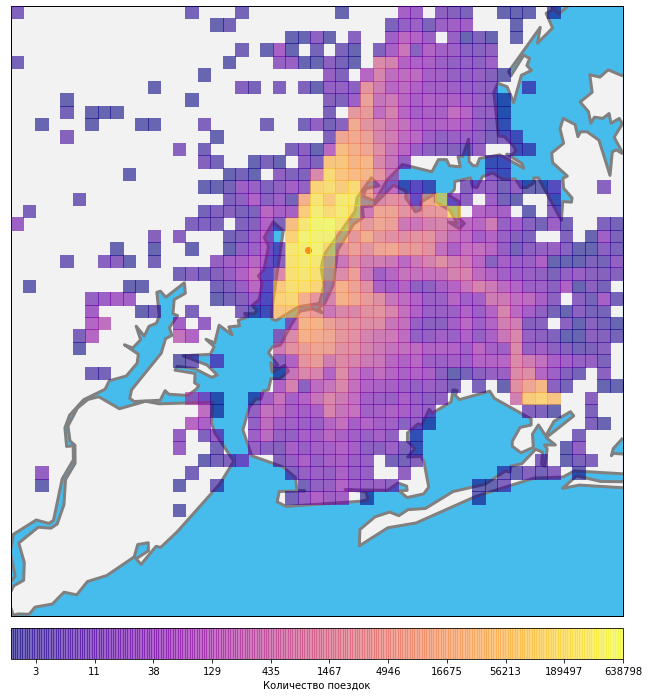

In [89]:
colordata = np.transpose(ser['count'].values.reshape(50, 50))
# изображение лучше, если цвета отображаются в логарифмическом масштабе
# но надо обработать ln(0). В результате заменим и нулевые значения на nan
# Замена 0 на nan сделана для не отображения в pcolormesh нулевых значений.
colordata = np.ma.log(colordata).filled(0)
colordata[colordata == 0] = np.nan


ColorInd = plt.get_cmap('plasma')
fig = plt.figure(figsize=(12, 12))
m = Basemap(resolution='h',  # h is nice
            projection='merc',
            llcrnrlon=coord_NY[0][0],
            llcrnrlat=coord_NY[0][1],
            urcrnrlon=coord_NY[1][0],
            urcrnrlat=coord_NY[1][1]
            )
# m.etopo(scale=.5, alpha=0.5)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines(color='gray', linewidth=3.0)  # intentionally thick line

lons, lats = m(-73.9856546198733, 40.7484284)
m.scatter(lons, lats, marker = 'o', color='r', zorder=5)

# Отфильтруем квадраты, у которых все четыре угла в воде
for i in range(0, colordata.shape[0]):
    for j in range(0, colordata.shape[1]):
        if not np.isnan(colordata[j,i]):
            reg = colordata.shape[0]*i+j+1
            x1,y1 = m(dictGrid[reg]['west'], dictGrid[reg]['south'])
            x2,y2 = m(dictGrid[reg]['west'], dictGrid[reg]['north'])
            x3,y3 = m(dictGrid[reg]['east'], dictGrid[reg]['north'])
            x4,y4 = m(dictGrid[reg]['east'], dictGrid[reg]['south'])
            if not ( m.is_land(x1,y1) or m.is_land(x2,y2) or m.is_land(x3,y3) or m.is_land(x4,y4) ):
                colordata[j,i] = np.nan 

# Сделать по координатам сетки
x = linspace(0, m.urcrnrx, colordata.shape[1])
y = linspace(0, m.urcrnry, colordata.shape[0])

xx, yy = meshgrid(x, y)

colormesh = m.pcolormesh(xx, yy, colordata, cmap=ColorInd, 
                         zorder=10,  alpha=0.6) # , vmin = 0.) #, vmax = 1300, cmap=cmap)

cb = m.colorbar(colormesh, location='bottom', label="Количество поездок")
alabel = linspace(0, np.nanmax(colordata), 12)
cb.set_ticks( alabel  )
cb.set_ticklabels ([str(int(i)) for i in  np.e**alabel])

plt.show()

C:\ProgramData\Anaconda2\envs\newpy\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


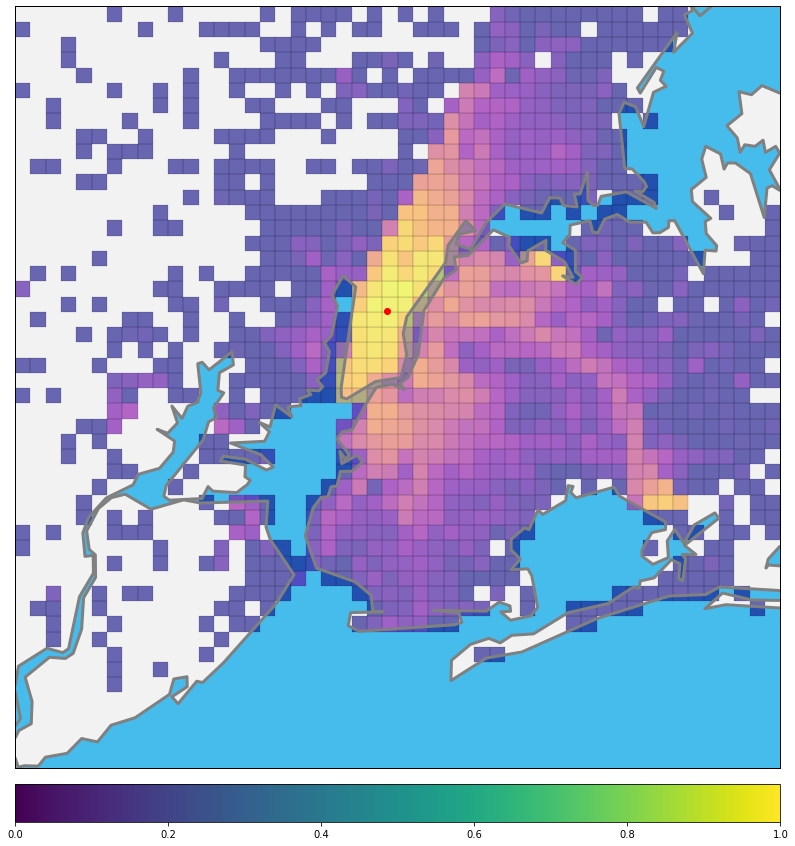

In [46]:
# ColorInd = plt.get_cmap('viridis') 
ColorInd = plt.get_cmap('plasma')

# ColorInd = plt.get_cmap('Spectral')
# Normalize
norm = matplotlib.colors.LogNorm(vmin=ser[ser['count']>5]['count'].min(), 
                                   vmax=ser[ser['count']>5]['count'].max())


fig = plt.figure(figsize=(15, 15))
m = Basemap(resolution='h',  # h is nice
            projection='merc',
            llcrnrlon=coord_NY[0][0],
            llcrnrlat=coord_NY[0][1],
            urcrnrlon=coord_NY[1][0],
            urcrnrlat=coord_NY[1][1]
            )
# m.etopo(scale=.5, alpha=0.5)

m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines(color='gray', linewidth=3.0)  # intentionally thick line

lons, lats = m(-73.9856546198733, 40.7484284)
m.scatter(lons, lats, marker = 'o', color='r', zorder=5)

for index, row in ser[ser['count']>0].iterrows():
    x1,y1 = m(dictGrid[row['region']]['west'], dictGrid[row['region']]['south'])
    x2,y2 = m(dictGrid[row['region']]['west'], dictGrid[row['region']]['north'])
    x3,y3 = m(dictGrid[row['region']]['east'], dictGrid[row['region']]['north'])
    x4,y4 = m(dictGrid[row['region']]['east'], dictGrid[row['region']]['south'])
    if m.is_land(x1,y1) or m.is_land(x2,y2) or m.is_land(x3,y3) or m.is_land(x4,y4):
        poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],
                       facecolor=ColorInd(norm(row['count'])), # 'green', row['count']
#                        facecolor=ColorInd(math.log(row['count'])),
                       edgecolor='black',
                       linewidth=.2, alpha=0.6)
        plt.gca().add_patch(poly)
#     else:
#         print('Отбрасываем регион: {}'.format(row['region']))
    
    
    
# Точки рисует хорошо    
#     lons, lats = m( dictGrid[row['region']]['west'], dictGrid[row['region']]['south'])
#     m.scatter(lons, lats, marker = 'o', color='g', zorder=5) 
m.colorbar(location="bottom")
# plt.colorbar(orientation="horizontal", 
#              boundaries=np.linspace(6, 638799, 10))

plt.show()

In [111]:
[norm(i) for i in  np.linspace(6, 638799, 10)]

[0.0,
 0.8101910777076506,
 0.870067522523903,
 0.9050939161267151,
 0.9299457928717183,
 0.9492225129630087,
 0.9649727950107709,
 0.9782895006745754,
 0.9898249760287169,
 1.0]

In [19]:
wl = -74.04006
sl = 40.683092
el = -73.834067
nl = 40.88378

m = Basemap(resolution='f', # c, l, i, h, f or None
            projection='merc',
            area_thresh=50,
            lat_0=(wl + sl)/2, lon_0=(el + nl)/2,
            llcrnrlon= wl, llcrnrlat= sl, urcrnrlon= el, urcrnrlat= nl)

m.drawmapboundary(fill_color='#46bcec')
# m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
# m.drawcoastlines()
# m.drawrivers()

C:\ProgramData\Anaconda2\envs\newpy\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


OSError: Unable to open boundary dataset file. Only the 'crude' and  'low',
resolution datasets are installed by default.
If you are requesting an, 'intermediate', 'high' or 'full'
resolution dataset, you may need to download and install those
files separately with
`conda install -c conda-forge basemap-data-hires`.

Opening: http://a.tile.openstreetmap.org/10/301/384.png
Couldn't download image
Opening: http://a.tile.openstreetmap.org/10/301/385.png
Couldn't download image


C:\ProgramData\Anaconda2\envs\newpy\lib\site-packages\ipykernel_launcher.py:104: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


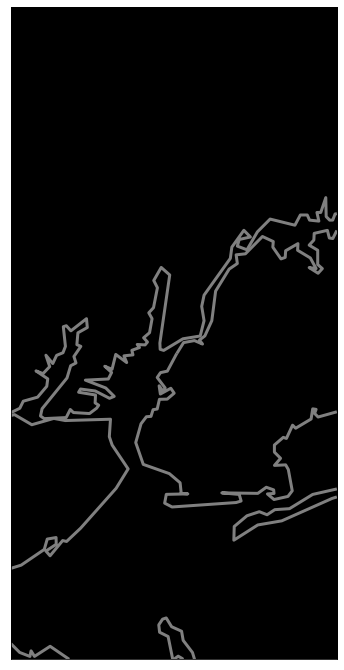

In [28]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import math
# import urllib2
# import StringIO
from PIL import Image

# === Begin block1 ===
# Credit: BerndGit, answered Feb 15 '15 at 19:47. And ...
# Source: https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames

def deg2num(lat_deg, lon_deg, zoom):
    '''Lon./lat. to tile numbers'''
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
    '''Tile numbers to lon./lat.'''
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)   # NW-corner of the tile. 

def getImageCluster(lat_deg, lon_deg, delta_lat, delta_long, zoom):
    # access map tiles from internet
    # no access/key or password is needed
    smurl = r"http://a.tile.openstreetmap.org/{0}/{1}/{2}.png"
    # useful snippet: smurl.format(zoom, xtile, ytile) -> complete URL
    # x increases L-R; y Top-Bottom
    xmin, ymax =deg2num(lat_deg, lon_deg, zoom)  # get tile numbers (x,y)
    xmax, ymin =deg2num(lat_deg+delta_lat, lon_deg+delta_long, zoom)

    # PIL is used to build new image from tiles
    Cluster = Image.new('RGB',((xmax-xmin+1)*256-1,(ymax-ymin+1)*256-1) ) 
    for xtile in range(xmin, xmax+1):
        for ytile in range(ymin,  ymax+1):
            try:
                imgurl = smurl.format(zoom, xtile, ytile)
                print("Opening: " + imgurl)
                imgstr = urllib2.urlopen(imgurl).read()
                # TODO: study, what these do?
                tile = Image.open(StringIO.StringIO(imgstr))
                Cluster.paste(tile, box=((xtile-xmin)*256 ,  (ytile-ymin)*255))
            except: 
                print("Couldn't download image")
                tile = None
    return Cluster
# ===End Block1===

# Credit to myself
def getextents(latmin_deg, lonmin_deg, delta_lat, delta_long, zoom):
    '''Return LL and UR, each with (long,lat) of real extent of combined tiles.
       latmin_deg: bottom lat of extent
       lonmin_deg: left long of extent
       delta_lat: extent of lat
       delta_long: extent of long, all in degrees
    '''
    # Tile numbers(x,y): x increases L-R; y Top-Bottom
    xtile_LL, ytile_LL = deg2num(latmin_deg, lonmin_deg, zoom)  #get tile numbers as specified by (x, y)
    xtile_UR, ytile_UR = deg2num(latmin_deg + delta_lat, lonmin_deg + delta_long, zoom)
    # from tile numbers, we get NW corners
    lat_NW_LL, lon_NW_LL = num2deg(xtile_LL, ytile_LL, zoom)
    lat_NW_LLL, lon_NW_LLL = num2deg(xtile_LL, ytile_LL+1, zoom) # next down below

    lat_NW_UR, lon_NW_UR = num2deg(xtile_UR, ytile_UR, zoom)
    lat_NW_URR, lon_NW_URR = num2deg(xtile_UR+1, ytile_UR, zoom) # next to the right
    # get extents
    minLat = lat_NW_LLL
    minLon = lon_NW_LL
    maxLat = lat_NW_UR
    maxLon = lon_NW_URR
    return (minLon, maxLon, minLat, maxLat)  # (left, right, bottom, top) in degrees

# OP's values of extents for target area to plot
# some changes here (with larger zoom level) may lead to better final plot
wl = -74.04006
sl = 40.683092
el = -73.834067
nl = 40.88378

lat_deg = sl
lon_deg = wl
d_lat = nl - sl
d_long = el - wl
zoom = 10   # zoom level

# Acquire images. The combined images will be slightly larger that the extents
timg = getImageCluster(lat_deg, lon_deg, d_lat, d_long, zoom)

# This computes real extents of the combined tile images, and get (left, right, bottom, top)
latmin_deg, lonmin_deg, delta_lat, delta_long = sl, wl, nl-sl, el-wl
(left, right, bottom, top) = getextents(latmin_deg, lonmin_deg, delta_lat, delta_long, zoom)   #units: degrees

# Set Basemap with proper parameters
m = Basemap(resolution='h',  # h is nice
            projection='merc',
            area_thresh=50,
            lat_0=(bottom + top)/2, lon_0=(left + right)/2,
            llcrnrlon=left, llcrnrlat=bottom, urcrnrlon=right, urcrnrlat=top)

fig = plt.figure()
fig.set_size_inches(10, 12)
m.imshow(np.asarray(timg), extent=[left, right, bottom, top], origin='upper' )
m.drawcoastlines(color='gray', linewidth=3.0)  # intentionally thick line
#m.fillcontinents(color='#f2f2f2', lake_color='#46bcec', alpha=0.6)
plt.show()

conda install -c conda-forge ipyleaflet

На мысль натолкнуло следующее: при выполнении команд
!jupyter nbextension enable --py widgetsnbextension --sys-prefix  
!jupyter nbextension enable --py --sys-prefix ipyleaflet  
первая команда прошла нормально, а вторая - сообщение об отсутствии пакета ipyleaflet. Было очень похоже, что поиск идет в 2.7. 


В UBUNTU помогла установка под (py37)
conda install nb_conda

запуск произвел так:
(py37) adm-net@admnet:~/Документы$ ~/anaconda2/bin/jupyter notebook 



In [7]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension enable --py --sys-prefix ipyleaflet


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok
Enabling notebook extension jupyter-leaflet/extension...
      - Validating: ok


In [4]:
!jupyter nbextension enable ipyleaflet --py --sys-prefix

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: ok


In [5]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [8]:
center = [34.6252978589571, -77.34580993652344]
zoom = 10
m = Map(center=center, zoom=zoom)

In [136]:
 [matplotlib.colors.rgb2hex(ColorInd(i)) for i in np.arange(0, 1.1, 0.05)]

['#0d0887',
 '#2a0593',
 '#41049d',
 '#5601a4',
 '#6a00a8',
 '#7e03a8',
 '#8f0da4',
 '#a11b9b',
 '#b12a90',
 '#bf3984',
 '#cc4778',
 '#d6556d',
 '#e16462',
 '#ea7457',
 '#f2844b',
 '#f89540',
 '#fca636',
 '#feba2c',
 '#fcce25',
 '#f7e425',
 '#f0f921',
 '#f0f921']

In [92]:
import pandas as pd
import ipywidgets as widgets

from ipyleaflet import Map, Heatmap, Rectangle, LayerGroup


m= Map(center=[ 40.7484284, -73.9856546198733], zoom = 10)
rectangle = Rectangle(bounds=( (coord_NY[0][1], coord_NY[0][0]), (coord_NY[1][1], coord_NY[1][0])),
                     weight=1, fill=False)


group = LayerGroup(layers=(rectangle,))
m.add_layer(group)
# m.add_layer(rectangle)

i=0

# for index, row in ser.iterrows():
#     p0 = (dictGrid[row['region']]['south'], dictGrid[row['region']]['west'])
# #     x2,y2 = m(dictGrid[row['region']]['west'], dictGrid[row['region']]['north'])
#     p1 = (dictGrid[row['region']]['north'], dictGrid[row['region']]['east'])
#     if i > 200:
#         break
#     else:
#         i+=1
#         stcol = lcolor[i//10]
    
        
#     x4,y4 = m(dictGrid[row['region']]['east'], dictGrid[row['region']]['south'])

#     r = Rectangle( bounds = (p0, p1), fill_opacity=0.4, stroke=False, 
#                        fill_color=stcol )
#     matplotlib.colors.rgb2hex(ColorInd((row['count'])))
#                  )
# #                        facecolor=ColorInd(math.log(row['count'])),
#                        edgecolor='black',
#                        weight=.2, fill_opacity=0.6
#                     )
#     group.add_layer(r)
#     m.add_layer(r)

    

heat_data = []
norm = matplotlib.colors.LogNorm(vmin=ser['count'].min(), 
                                   vmax=ser['count'].max())
for index, row in ser[ser['count'] > 5 ].iterrows():
    heat_data.append( (dictGrid[row['region']]['south'], dictGrid[row['region']]['west'],  
                       row['count']))

# heat_data    
lcolor = { round(i, 2): matplotlib.colors.rgb2hex(ColorInd(i)) for i in np.arange(0, 1.1, 0.2)}
heat = Heatmap(locations=heat_data) # , gradient=lcolor ) # , radius=6, blur=10.5)
#                  min = math.log(ser['count'].min()), max = math.log(ser['count'].max()))
m.add_layer(heat)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [ ]:
###### Change some attributes of the heatmap
heat.radius = 6
heat.blur = 10
heat.max = 1.
heat.min_opacity = 0.
# heat.max = 0.5
heat.gradient = {0.4: 'red', 0.6: 'yellow', 0.7: 'lime', 0.8: 'cyan', 1.0: 'blue'}
# heat.gradient = { round(i, 2): matplotlib.colors.rgb2hex(ColorInd(i)) for i in np.arange(0, 1.1, 0.05)}
# {0.4: 'red', 0.6: 'yellow', 0.4: 'lime', 0.4: 'cyan', 1.0: '#ae2892'}

In [182]:
# matplotlib.colors.rgb2hex(ColorInd(100))
heat.locations
heat.max
heat.min_opacity


0.05

In [41]:
m.remove_layer(heatmap)

Думаю, можно без нее
conda install -c conda-forge folium 


conda install -c conda-forge ipywidgets

https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916

https://ipyleaflet.readthedocs.io/en/latest/api_reference/widget_control.html

https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html

In [97]:
from IPython.display import display
slider = widgets.IntSlider(
    min=0,
    max=23,
    step=1,
    description='Выбор часа:',
    value=12
)


display(slider)

IntSlider(value=12, description='Выбор часа:', max=23)

In [106]:
{ round(i, 2): matplotlib.colors.rgb2hex(ColorInd(i)) for i in np.arange(0, 1.1, 0.1)}

{0.0: '#0d0887',
 0.1: '#41049d',
 0.2: '#6a00a8',
 0.3: '#8f0da4',
 0.4: '#b12a90',
 0.5: '#cc4778',
 0.6: '#e16462',
 0.7: '#f2844b',
 0.8: '#fca636',
 0.9: '#fcce25',
 1.0: '#f0f921'}